<H1>Statistical Analysis on Bike Sharing Dataset

**Context**

Bike sharing systems are a new generation of traditional bike rentals where the whole process from membership, rental and return back has become automatic. Through these systems, user is able to easily rent a bike from a particular position and return back to another position. Currently, there are about over 500 bike-sharing programs around the world which are composed of over 500 thousands bicycles. Today, there exists great interest in these systems due to their important role in traffic, environmental and health issues.

Apart from interesting real-world applications of bike sharing systems, the characteristics of data being generated by these systems make them attractive for the research. Opposed to other transport services such as bus or subway, the duration of travel, departure and arrival position is explicitly recorded in these systems. This feature turns bike sharing system into a virtual sensor network that can be used for sensing mobility in the city. Hence, it is expected that most of important events in the city could be detected via monitoring these data.

This dataset contains the hourly and daily count of rental bikes between years 2011 and 2012 in Capital bikeshare system in Washington, DC with the corresponding weather and seasonal information.

**Content**

Both hour.csv and day.csv have the following fields, except hr which is not available in day.csv

    instant: Record index
    dteday: Date
    season: Season (1:springer, 2:summer, 3:fall, 4:winter)
    yr: Year (0: 2011, 1:2012)
    mnth: Month (1 to 12)
    hr: Hour (0 to 23)
    holiday: weather day is holiday or not (extracted from Holiday Schedule)
    weekday: Day of the week
    workingday: If day is neither weekend nor holiday is 1, otherwise is 0.
    weathersit: (extracted from Freemeteo)
    1: Clear, Few clouds, Partly cloudy, Partly cloudy
    2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
    temp: Normalized temperature in Celsius. The values are derived via (t-tmin)/(tmax-tmin), tmin=-8, t_max=+39 (only in hourly scale)
    atemp: Normalized feeling temperature in Celsius. The values are derived via (t-tmin)/(tmax-tmin), tmin=-16, t_max=+50 (only in hourly scale)
    hum: Normalized humidity. The values are divided to 100 (max)
    windspeed: Normalized wind speed. The values are divided to 67 (max)
    casual: count of casual users
    registered: count of registered users
    cnt: count of total rental bikes including both casual and registered


>Importing Libraries

In [2]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline

import researchpy as rp
from scipy import stats
from sklearn.preprocessing import scale

>Looking at the Data

In [3]:
df = pd.read_csv('J:/Datasets/bike-sharing-dataset/day.csv')
df.tail()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
726,727,2012-12-27,1,1,12,0,4,1,2,0.254167,0.226642,0.652917,0.350133,247,1867,2114
727,728,2012-12-28,1,1,12,0,5,1,2,0.253333,0.255046,0.590000,0.155471,644,2451,3095
728,729,2012-12-29,1,1,12,0,6,0,2,0.253333,0.242400,0.752917,0.124383,159,1182,1341
729,730,2012-12-30,1,1,12,0,0,0,1,0.255833,0.231700,0.483333,0.350754,364,1432,1796
730,731,2012-12-31,1,1,12,0,1,1,2,0.215833,0.223487,0.577500,0.154846,439,2290,2729


In [4]:
df.shape

(731, 16)

>Data Munging

How may Bikes are rented on workingdays, weekends and in different seasons ?


In [5]:
#Removing other features which are not relevant.
df = df[['season','mnth','holiday','workingday','weathersit','temp','cnt']]

In [6]:
df.head()

,season,mnth,holiday,workingday,weathersit,temp,cnt
0,1,1,0,0,2,0.344167,985
1,1,1,0,0,2,0.363478,801
2,1,1,0,1,1,0.196364,1349
3,1,1,0,1,1,0.200000,1562
4,1,1,0,1,1,0.226957,1600


In [7]:
#saving the processed file in directory
df.to_csv('J:/Datasets/bike-sharing-dataset/day_processed.csv', index=False)

In [8]:
df['season'].unique() #Season are of 4 types - 1.Spring 2.Summer 3.Fall 4.Winter

array([1, 2, 3, 4], dtype=int64)

In [9]:
df['workingday'].unique() #Working day or Weekend - 0.workingday , 1.notworkingday

array([0, 1], dtype=int64)

In [10]:
df['holiday'].unique() # 0.no holiday, 1.holiday

array([0, 1], dtype=int64)

In [11]:
df['weathersit'].unique() # 1.Clear,few clouds, 2.misty,cloud, 3.Light snow,rain,thunderstorm

array([2, 1, 3], dtype=int64)

In [12]:
df['temp'].describe() #temp in celsius

count    731.000000
mean       0.495385
std        0.183051
min        0.059130
25%        0.337083
50%        0.498333
75%        0.655417
max        0.861667
Name: temp, dtype: float64

Number of bikes rented on working day and non working day.

In [13]:
df.groupby('workingday')['cnt'].describe()

,count,mean,std,min,25%,50%,75%,max
workingday,,,,,,,,
0,231.0,4330.168831,2052.141245,605.0,2710.50,4459.0,5907.5,8714.0
1,500.0,4584.820000,1878.415583,22.0,3344.25,4582.0,5987.5,8362.0


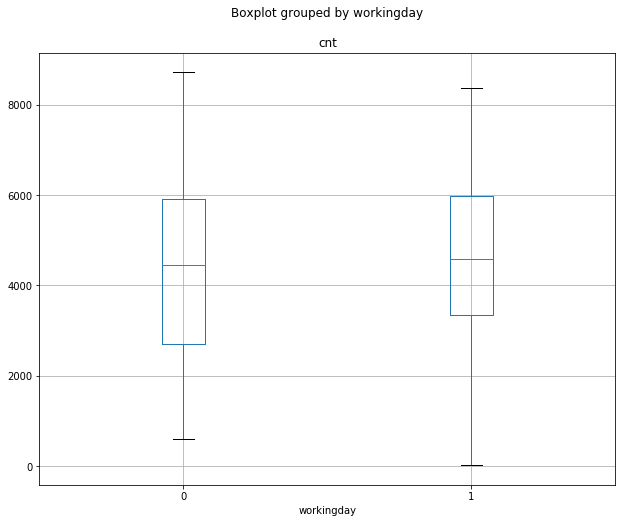

In [14]:
df.boxplot(column=['cnt'],by='workingday',figsize=(10,8))

In [15]:
sample_01 = df[(df['workingday']==1)] #working days
sample_02 = df[(df['workingday']==0)] #non working days

In [16]:
sample_01.shape, sample_02.shape

((500, 7), (231, 7))

In [17]:
#equalizing both samples to apply t-test
sample_01 = sample_01.sample(231)
sample_01.shape,sample_02.shape

((231, 7), (231, 7))

>Levene t-test

In [18]:
#Levene's t-test To check whether the variance of two groups are same.
#null hypothesis - the variances of two groups are same.
#alternate hypothesis - the variance of two groups are different
stats.levene(sample_01['cnt'], sample_02['cnt'])
#test statistic is 3.63 and p-value is 0.57

LeveneResult(statistic=2.787211303444122, pvalue=0.09569979160702412)

**Result** - The signigicance level is 5% = 0.05, because we have  so we can reject alternate hypothesis and accept null hypothesis.

The distribution of the residuals between the two groups should follow the normal distribution.

'" \'scale\' function will standardized the results. Standadization subtracts mean from the \nobservations(every value) and divides with standard deviation so the resulting samples have \n0 mean and unit variance and unit standard deviation  '

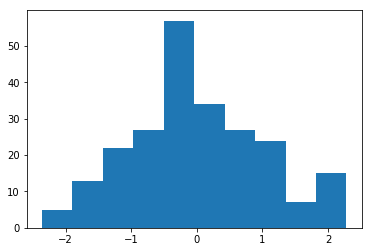

In [19]:
diff = scale(np.array(sample_01['cnt'])-np.array(sample_02['cnt'], dtype=np.float))
plt.hist(diff)

"""" 'scale' function will standardized the results. Standadization subtracts mean from the 
observations(every value) and divides with standard deviation so the resulting samples have 
0 mean and unit variance and unit standard deviation  """



Generating probability plot of sample data against the quantiles of a theoritical distibution
It is also known as QQplot

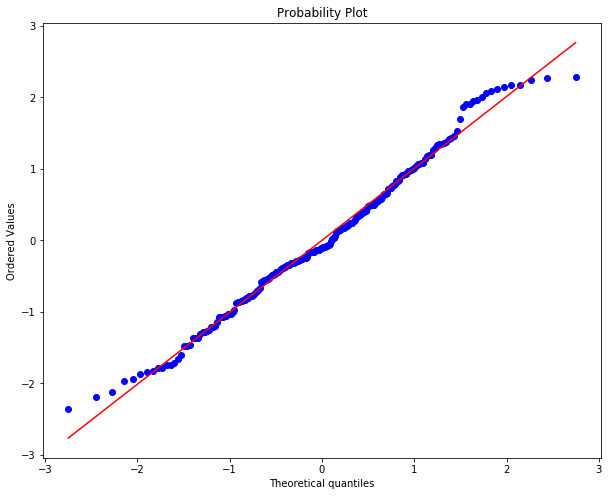

In [20]:
plt.figure(figsize=(10,8))
stats.probplot(diff, plot = plt, dist='norm')
plt.show()

Result - Residual data closely follows quantile information of normally distributed data, greater than '2 standard deviations' away from the mean the rest of the data is very close to be normally distributed and does not track the red line.

So we can accept the independent t-test been satisfied because most of the data is normally distributed and on the line.

>Shapiro - Wilk t-test for Normality

If the test statistic is not significant then population is normally distributed.

In [21]:
stats.shapiro(diff)
#p-value is 0.38 - 38%

(0.9888110160827637, 0.06954458355903625)

Hence shapiro test is not significant and our residual data is normally distributed.

>Independent t-test

In [22]:
stats.ttest_ind(sample_01['cnt'],sample_02['cnt'])

Ttest_indResult(statistic=1.8873382024081284, pvalue=0.059744161237204926)

**Interpretation:** We reject null hypothesis and accept alternate hypothesis.
Null Hypothesis says no difference and alternative hypothesis says there is a difference.

**Result:** Whether its a working day or not has no effect on no. of bikes shared or rented.

In [23]:
descriptives, results = rp.ttest(sample_01['cnt'],sample_02['cnt'])

In [24]:
descriptives
#bikes shared on working and non-working days, there mean and standard deviation

,Variable,N,Mean,SD,SE,95% Conf.,Interval
0,cnt,231.0,4676.277056,1886.054559,124.093279,4431.772125,4920.781988
1,cnt,231.0,4330.168831,2052.141245,135.020981,4064.132702,4596.204960
2,combined,462.0,4503.222944,1976.317217,91.946598,4322.536549,4683.909339


In [25]:
print(results)

          Independent t-test   results
0  Difference (cnt - cnt) =   346.1082
1      Degrees of freedom =   460.0000
2                       t =     1.8873
3   Two side test p value =     0.0597
4  Difference < 0 p value =     0.9701
5  Difference > 0 p value =     0.0299
6               Cohen's d =     0.1756
7               Hedge's g =     0.1753
8           Glass's delta =     0.1835
9                       r =     0.0877


**Interpretation:** accept null Hypothesis and reject alternate hypothesis

**Results:** It doesn't matter whether it is a working day or not has no effect on bikes shared

>Performing Welch's Test

In [28]:
df.head()

,season,mnth,holiday,workingday,weathersit,temp,cnt
0,1,1,0,0,2,0.344167,985
1,1,1,0,0,2,0.363478,801
2,1,1,0,1,1,0.196364,1349
3,1,1,0,1,1,0.200000,1562
4,1,1,0,1,1,0.226957,1600


Box Plot Representation of temperature

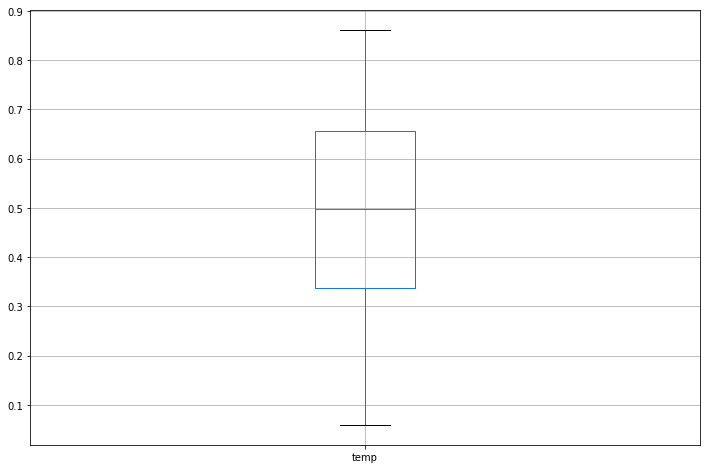

In [29]:
df[['temp']].boxplot(figsize = (12,8))

Values are scaled from 0 to 1 and median temperature is 0.5

Adding new category of temp showing days above and below the average

In [30]:
df['temp_category'] = df['temp'] > df['temp'].mean()

In [32]:
df.head(10)

,season,mnth,holiday,workingday,weathersit,temp,cnt,temp_category
0,1,1,0,0,2,0.344167,985,False
1,1,1,0,0,2,0.363478,801,False
2,1,1,0,1,1,0.196364,1349,False
3,1,1,0,1,1,0.200000,1562,False
4,1,1,0,1,1,0.226957,1600,False
5,1,1,0,1,1,0.204348,1606,False
6,1,1,0,1,2,0.196522,1510,False
7,1,1,0,0,2,0.165000,959,False
8,1,1,0,0,1,0.138333,822,False
9,1,1,0,1,1,0.150833,1321,False


How temperatur affects our bike count ?

In [33]:
df.groupby('temp_category')['cnt'].describe()

,count,mean,std,min,25%,50%,75%,max
temp_category,,,,,,,,
False,364.0,3387.664835,1691.340133,22.0,1964.5,3301.0,4513.5,8090.0
True,367.0,5611.904632,1475.698228,1115.0,4548.5,5336.0,6897.5,8714.0


This shows that bikes are rented in warmer days more than cooler days.

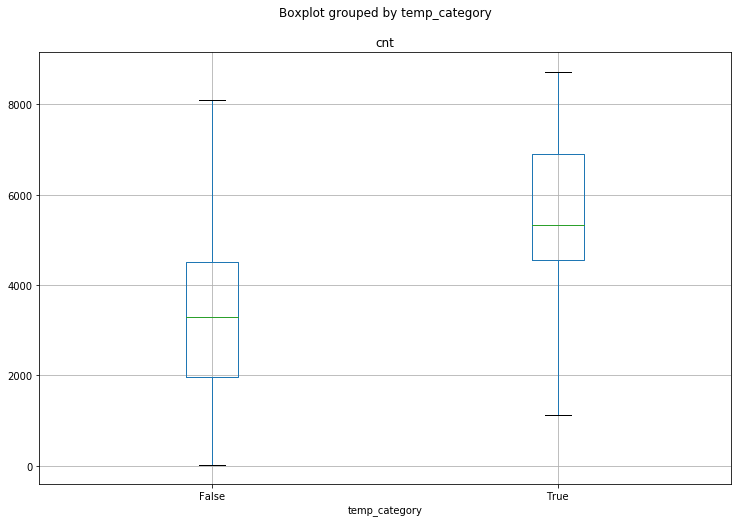

In [34]:
#Visualization
df.boxplot(column = ['cnt'], by = 'temp_category', figsize = (12,8))

Theie are differences in boxplot lets check whether the difference is significant. T-test will be applied to check significance..


In [37]:
 #No.of samples in two groups have to be exactly the same.
sample_01 = df[(df['temp_category'])==True]   
sample_01 = sample_01.sample(364)
sample_02 = df[(df['temp_category'])==False] 
sample_01.shape, sample_02.shape

((364, 8), (364, 8))

In [38]:
"""test the assumptions for the independent t-test. First we rum levene's t-test to find significant 
differences of variances of two samples of data."""

stats.levene(sample_01['cnt'], sample_02['cnt'])

LeveneResult(statistic=4.722933805528485, pvalue=0.0300855284887842)

p-value = 0.03 which shows levene's test is significant and we need to reject null hypothesis and accept alternate hypothesis. (significance level = 5%).

Variances between two samples are different, this implies one of the assumptions of independent t-test is not satisfied.

If we run independent t-test on data we cant rely on results completely.

(array([12., 24., 24., 52., 52., 72., 73., 27., 20.,  8.]),
 array([-2.42595186, -1.94453096, -1.46311007, -0.98168917, -0.50026827,
        -0.01884738,  0.46257352,  0.94399441,  1.42541531,  1.90683621,
         2.3882571 ]),
 <a list of 10 Patch objects>)

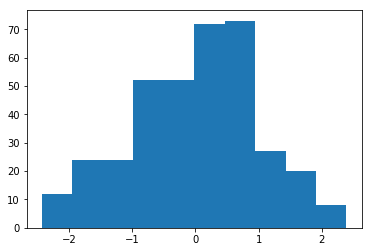

In [40]:
#checking second assumptions of difference between two residuals are normally distributed.
diff = scale(np.array(sample_01['cnt']) - np.array(sample_02['cnt']))
plt.hist(diff)

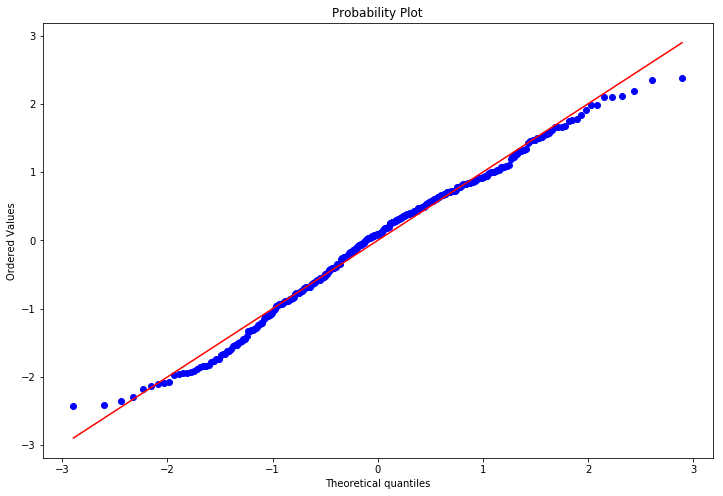

In [42]:
#QQplot or probability plot to check whether residuals are normally distributed.
plt.figure(figsize = (12,8))
stats.probplot(diff, plot = plt)
plt.show()

In [45]:
#To test for normality
stats.shapiro(diff)

(0.9887695908546448, 0.006676464807242155)

The p-value here is 3%, if our cut-off is 5% we to accept alternate hypothesis and the residuals are not normally distributed.

In [48]:
#Independent t-test
stats.ttest_ind(sample_01['cnt'], sample_02['cnt'])

Ttest_indResult(statistic=18.813507976707154, pvalue=1.2796388969076982e-64)

the p-value is very tiny and way below 5%, this implies the test results are significant.

The count of bike sharing on hot days vs cooler days means are significantly different.


In [51]:
#Welch's t-test
descriptives, results = rp.ttest(sample_01['cnt'], sample_02['cnt'], equal_variances =False)

In [53]:
descriptives

,Variable,N,Mean,SD,SE,95% Conf.,Interval
0,cnt,364.0,5602.719780,1478.234685,77.480550,5450.352679,5755.086882
1,cnt,364.0,3387.664835,1691.340133,88.650311,3213.332169,3561.997501
2,combined,728.0,4495.192308,1935.907708,71.749513,4354.331337,4636.053279


In [55]:
print(results)

              Welch's t-test    results
0  Difference (cnt - cnt) =   2215.0549
1      Degrees of freedom =    713.2194
2                       t =     18.8135
3   Two side test p value =      0.0000
4  Difference < 0 p value =      1.0000
5  Difference > 0 p value =      0.0000
6               Cohen's d =      1.3945
7               Hedge's g =      1.3931
8           Glass's delta =      1.4984
9                       r =      0.5759


p-value close to 0 and t-test is 18.813 shows significant of warm and cool affect the no. of bikes rented